# Feature Selection with the D-Wave System
> This notebook demonstrates the formulation of an  (nk)  optimization problem for solution on a D-Wave quantum computer. The method used in the example problem of this notebook—feature-selection for machine learning— is applicable to problems from a wide range of domains; for example feature selection in recommenders.

- toc: true
- badges: true
- comments: true
- categories: [FeatureSelection, Featurization, DWave, QuantumComputation]
- image:

The promise of quantum computing to open new unexplored possibilities in several scientific fields has been long discussed, but until recently the lack of a functional quantum computer has confined this discussion mostly to theoretical algorithmic papers. It was only in the last few years that small but functional quantum computers have become available to the broader research community. One paradigm in particular,quantum annealing, can be used to sample optimal solutions for a number of NP-hard optimization problems represented with classical operations research tools, providing an easy access to the potential of this emerging technology. One of the tasks that most naturally fits in this mathematical formulation is feature selection. In this tutorial, we will learn how to run feature selection algorithm. We represent the feature selection as an optimization problem and solve it on a real quantum computer, provided by D-Wave. The results indicate that the proposed approach is effective in selecting a limited set of important features and that quantum computers are becoming powerful enough to enter the wider realm of applied science.

This notebook demonstrates the formulation of an $n \choose k$ optimization problem for solution on a D-Wave quantum computer. The method used in the example problem of this notebook&mdash;feature-selection for machine learning&mdash; is applicable to problems from a wide range of domains; for example financial portfolio optimization. 
    
1. [What is Feature Selection?](#What-is-Feature-Selection?) defines and explains the feature-selection problem.
2. [Feature Selection by Mutual Information](#Feature-Selection-by-Mutual-Information) describes a particular method of feature selection that is demonstrated in this notebook.
3. [Solving Feature Selection on a Quantum Computer](#Solving-Feature-Selection-on-a-Quantum-Computer) shows how such optimization problems can be formulated for solution on a D-Wave quantum computer. 
4. [Example Application: Predicting Survival of Titanic Passengers](#Example-Application:-Predicting-Survival-of-Titanic-Passengers) demonstrates the use of *Kerberos*, an out-of-the-box classical-quantum [hybrid](https://github.com/dwavesystems/dwave-hybrid) sampler, to select optimal features for a public-domain dataset. 

This notebook should help you understand both the techniques and [Ocean software](https://github.com/dwavesystems) tools used for solving optimization problems on D-Wave quantum computers.

## What is Feature Selection?
Statistical and machine-learning models use sets of input variables ("features") to predict output variables of interest. Feature selection can be part of the model design process: selecting from a large set of potential features a highly informative subset simplifies the model and reduces dimensionality. 

For example, to build a model that predicts the ripening of hothouse tomatoes, Farmer MacDonald daily records the date, noontime temperature, daylight hours, degree of cloudiness, rationed water and fertilizer, soil humidity, electric-light hours, etc. These measurements constitute a list of potential features. After a growth cycle or two, her analysis reveals some correlations between these features and crop yields:

* fertilizer seems a strong predictor of fruit size
* cloudiness and daylight hours seem poor predictors of growth 
* water rations and soil humidity seem a highly correlated pair of strong predictors of crop rot   

Farmer MacDonald suspects that her hothouse's use of electric light reduces dependency on seasons and sunlight. She can simplify her model by discarding date, daylight hours, and cloudiness. She can record just water ration or just soil humidity rather than both.

For systems with large numbers of potential input information&mdash;for example, weather forecasting or image recognition&mdash;model complexity and required compute resources can be daunting. Feature selection can help make such models tractable. 

However, optimal feature selection can itself be a hard problem. This example introduces a powerful method of optimizing feature selection based on a complex probability calculation. This calculation is submitted for solution to a quantum computer. 

## Setup

In [ ]:
!pip install dimod
!pip install dwave_networkx
!pip install dwave-ocean-sdk
!pip install -U requests

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
import itertools
from scipy.optimize import curve_fit
from scipy.stats import linregress

import dimod
import dwave_networkx as dnx

%matplotlib inline

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv -u -t -d

Last updated: 2021-07-28 06:39:46

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

networkx      : 2.5.1
sys           : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
dwave_networkx: 0.8.8
pandas        : 1.1.5
matplotlib    : 3.2.2
numpy         : 1.19.5
dimod         : 0.9.15
IPython       : 5.5.0



In [ ]:
#@markdown plot utils
def sub_plot(size, small, big, x, subtitles, y, *y2):
    gs = GridSpec(big + 1, small)
    plt.figure(figsize=size)
    for i in range(small):
        ax = 'ax_' + str(i)
        ax = plt.subplot(gs[0, i])
        ax.set_title(subtitles[i])
        if y2:
            ax.plot(x, y2[0]['out'].values, 'ro')
            ax.plot(x, y[y.columns[i]].values, 'bv')
            ax.legend(["out", "model"])
        else:
            ax.plot(x, y[y.columns[i]].values)
        
    if big:
        axy = plt.subplot(gs[1, :])
        i += 1
        axy.set_title(y.columns[i])
        axy.plot(x, y[y.columns[i]].values, 'r') 
    return plt

def plot_toy_signals(df):
    sub_plot((10, 8), 3, True, np.linspace(-np.pi, np.pi, len(df)), df.columns, df)  
    plt.suptitle("Toy Problem: System Inputs and Output", fontsize=15)

def plot_two_var_model(df1, df2):
    subtitles = ["Modeling %s and %s" % f0f1 for f0f1 in df1.columns]
    sub_plot((12, 4), 3, 0, np.linspace(-np.pi, np.pi, len(df1)), subtitles, df1, df2) 
    plt.suptitle("Toy Problem: Output Vesus Two-Signal Model", fontsize=15)

def plot_lingress(df, toy):
    subtitles = ["%s correlation coefficient: %.2f" % var_rval for var_rval in df.columns]
    sub_plot((12, 4), 3, 0, np.linspace(-np.pi, np.pi, len(df)), subtitles, df, toy) 
    plt.suptitle("Toy Problem: Linear Regression", fontsize=15)

# Warning since 0.24.2
#def plot_se(data):
#    pd.DataFrame(data).plot(x='Bins', y=['Maximum', 'Uniform', 'Exp', 'Vals'], style = [ 'ro','b', 'g', 'y'])
#    plt.title("Shannon Entropy")
#    plt.ylabel("Entropy")
def plot_se(data):
    df = pd.DataFrame(data)
    plt.figure(figsize=(5, 4))
    plt.plot(df[['Bins']], df[['Maximum']], 'ro', 
             df[['Bins']], df[['Uniform']], 'b', 
             df[['Bins']], df[['Exp']], 'g', 
             df[['Bins']], df[['Vals']], 'y')
    plt.title("Shannon Entropy")
    plt.xlabel("Bins")
    plt.ylabel("Entropy")
    plt.legend(['Maximum', 'Uniform', 'Exp', 'Vals'])
    
def plot_mi(scores):
    if len(scores) > 5:
        plt.figure(figsize=(8, 5))
    else:
        plt.figure(figsize=(4, 4))
    labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.title("Mutual Information")
    plt.ylabel("MI with Variable of Interest")

def plot_solutions(result):
    features = []
    energies = []
    for sample, energy in result.data(['sample', 'energy']):
        energies.append(energy)
        features.append([key for (key, value) in sample.items() if value == 1])
    plt.figure(figsize=(4, 4))
    plt.bar(np.arange(len(features)), energies)
    plt.xticks(np.arange(len(features)), features, rotation=90)
    plt.title("Toy Problem: Unconstrained Solution")
    plt.ylabel("Energy")

def plot_features(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

## Illustrative Toy Problem
This subsection illustrates the use of feature selection with a simple example: a toy system with a single output generated from three inputs. 

The model built to predict the system's output is even simpler: it uses just two of three possible features (inputs). You can expect it to perform better when the selected two features are more independent, assuming all three contribute somewhat commensurately to the system output (if an independent feature contributes less than the difference between two dependent ones, this might not be true). In the case of Farmer MacDonalds's tomatoes, a model using rationed water and fertilizer should perform better than one using rationed water and soil humidity. 

The code cell below uses the NumPy library to define three inputs, the first two of which are very similar: a sine, a noisy sine, and a linear function with added random noise. It defines an output that is a simple linear combination of these three inputs.

In [ ]:
sig_len = 100
# Three inputs: in1 & in2 are similar 
in1 = np.sin(np.linspace(-np.pi, np.pi, sig_len)).reshape(sig_len, 1)
in2 = np.sin(np.linspace(-np.pi+0.1, np.pi+0.2, sig_len)).reshape(sig_len, 1) + 0.3*np.random.rand(sig_len, 1)
in3 = np.linspace(-1, 1, sig_len).reshape(sig_len,1) + 2*np.random.rand(sig_len, 1)

out = 2*in1 + 3*in2 + 6*in3

Plot the features and variable of interest (the output).

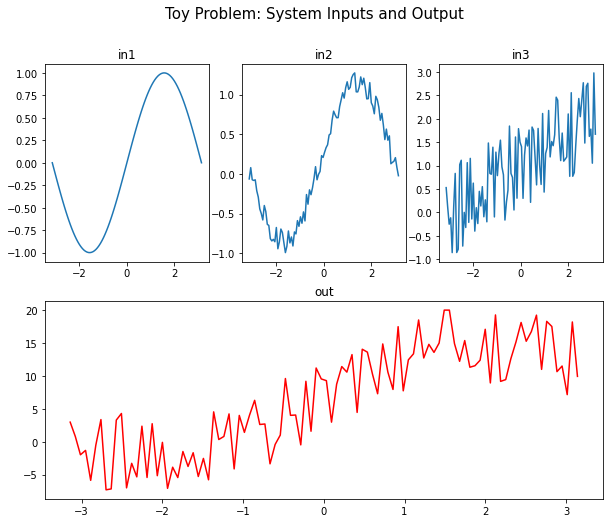

In [ ]:
# Store problem in a pandas DataFrame for later use
toy = pd.DataFrame(np.hstack((in1, in2, in3, out)), columns=["in1", "in2", "in3", "out"])

plot_toy_signals(toy)

The `two_var_model` function in the next cell defines a linear model of two variables. 

In [ ]:
def two_var_model(in_tuple, a, b):
    ina, inb = in_tuple
    return a*ina + b*inb

Use the SciPy library's `curve_fit` function to try to predict the variable of interest from two of three features. The model with less-correlated features performs better.

Standard deviation for selection of features in1 and in2 is 3.2589.
Standard deviation for selection of features in1 and in3 is 0.0746.
Standard deviation for selection of features in2 and in3 is 0.0540.


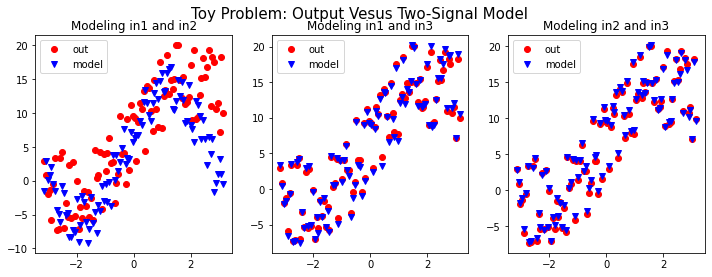

In [ ]:
model = []
two_vars = []
for f0, f1 in itertools.combinations(['in1', 'in2', 'in3'], 2):  
    two_vars.append((f0, f1))
    popt, pcov = curve_fit(two_var_model, (toy[f0].values, toy[f1].values), toy['out'].values)
    model.append(two_var_model((toy[f0].values, toy[f1].values), popt[0], popt[1]).reshape(len(toy), 1))
    print("Standard deviation for selection of features {} and {} is {:.4f}.".format(f0, f1, max(np.sqrt(np.diag(pcov)))))
model_df = pd.DataFrame(np.hstack(model), columns=two_vars)

plot_two_var_model(model_df, toy)

The following section introduces a method for optimizing feature selection that can be useful in modeling complex systems. 

## Feature Selection by Mutual Information
There are various methods for [feature selection](https://en.wikipedia.org/wiki/Feature_selection). If you are building a machine-learning model, for example, and have six potential features, you might naively consider training it first on each of the features by itself, then on all 15 combinations of subsets of two features, then 20 combinations of subsets of three features, and so on. However, statistical methods are more efficient.  

One statistical criterion that can guide this selection is mutual information (MI). The following subsections explain information and MI with some simple examples.

If you already understand MI and Shannon entropy, please skip ahead to section [Solving Feature Selection on a Quantum Computer](#Solving-Feature-Selection-on-a-Quantum-Computer) (and then from the menu bar, click the **Cell** drop-down menu's *Run All Above* option). 

### Quantifying Information: Shannon Entropy
[Shannon entropy](https://en.wiktionary.org/wiki/Shannon_entropy), $H(X)$,  mathematically quantifies the information in a signal:

$H(X) = - \sum_{x \in X} p(x) \log p(x)$

where $p(x)$ represents the probability of an event's occurrence. The Shannon Entropy (SE) formula can be understood as weighing by an event's probability a value of $\log \frac{1}{p(x)}$ for the event, where the reciprocal is due to the minus sign. This value means that the less likely the occurrence of an event, the more information is attributed to it (intuitively, when a man bites a dog it's news). 

To calculate SE, the `prob` function defined below calculates probability for a dataset representing some variables (a training set in a machine learning context) by dividing it into bins as a histogram using the NumPy library's `histogramdd` function.

In [ ]:
def prob(dataset, max_bins=10):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]

    freq, _ = np.histogramdd(dataset, bins)
    p = freq / np.sum(freq)
    return p

def shannon_entropy(p):
    """Shannon entropy H(X) is the sum of P(X)log(P(X)) for probabilty distribution P(X)."""
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

#### Illustration of Shannon Entropy
For an intuitive example of measuring SE, this subsection applies the `shannon_entropy` function to three signals with defined distributions:

* Uniform: this distribution maximizes values of SE because all outcomes are equally likely, meaning every outcome is equally unpredictable. $H(X) = log(N)$ for uniform distribution, where $N$ is the number of possible outcomes, ${x_1, x_2, ...x_N}$. 
* Exponential: the steeper the curve, the more outcomes are in the "tail" part (have higher probability) with lower information value. 
* Binomial: the stronger this signal is biased to one outcome, the more predictable its values, the lower its information value. $H(X) = -p \log(p) - (1-p) \log(1-p)$ for binomial distribution; for $p = 0.1$, for example, $H(X) = 0.468$.  

Define the three signals and plot the SE. The red dots show the maximal values of SE for different numbers of bits (Shannon developed the formula to calculate channel bandwidth, which for digital communications is measured in bits) or, as here, the bins into which the signals' possible values are divided.  

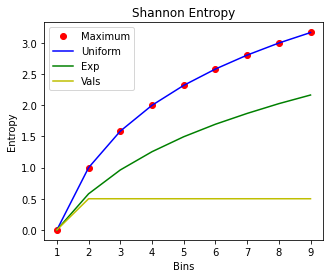

In [ ]:
max_bins = 10

# Signals with defined distributions
x_uniform = np.random.uniform(0, 1, (1000, 1))
x_exp = np.exp(-np.linspace(0, 10, 1000)/2).reshape(1000, 1)
x_vals = np.random.choice([0, 1],(1000, 1), p=[0.1, 0.9])

data = list()
for bins in range(1, max_bins):
    uniform_se = shannon_entropy(prob(x_uniform, bins))
    exp_se = shannon_entropy(prob(x_exp, bins))
    vals_se = shannon_entropy(prob(x_vals, bins))                               
    data.append({'Bins': bins, 'Uniform': uniform_se, 'Maximum': np.log2(bins), 'Exp': exp_se, 'Vals': vals_se})

plot_se(data)

#### Conditional Shannon Entropy

Conditional SE (CSE) measures the information in one signal, $X$, when the value of another signal, $Y$, is known: 

$\begin{aligned} H(X|Y) 
& = H(X,Y)-H(Y) \\
& = - \sum_{x \in X} p(x, y) \log p(x, y) - H(Y) \end{aligned}$

where joint SE, $H(X,Y)$, measures the information in both signals together, with $p(x,y)$ being their joint probability. For example, knowing that it's winter reduces the information value of news that it is raining.  

In [ ]:
def conditional_shannon_entropy(p, *conditional_indices):
    """Shannon entropy of P(X) conditional on variable j"""

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

#### Illustration of CSE 
Apply CSE to the toy problem. Because signals `in1` and `in2` are similar, knowing the value of one provides a good estimate of the other; in contrast, the value of signal `in3` is less good for estimating the first two.  

In [ ]:
print("H(in1) = {:.2f}".format(shannon_entropy(prob(toy[["in1"]].values))))
print("H(in1|in3) = {:.2f}".format(conditional_shannon_entropy(prob(toy[["in1", "in3"]].values), 1)))
print("H(in1|in2) = {:.2f}".format(conditional_shannon_entropy(prob(toy[["in1", "in2"]].values), 1)))

H(in1) = 3.16
H(in1|in3) = 2.31
H(in1|in2) = 1.16


### Mutual Information
[Mutual information](https://en.wikipedia.org/wiki/Mutual_information) between variables $X$ and $Y$ is defined as 

$I(X;Y)  = \sum_{y \in Y} \sum_{x \in X} p(x, y) \log \frac{p(x,y)}{p(x)p(y)}$

where $p(x)$ and $p(y)$ are marginal probabilities of $X$ and $Y$, and $p(x,y)$ the joint probability. Equivalently, 

$I(X;Y)  = H(Y) - H(Y|X)$

where $H(Y)$ is the SE of $Y$ and $H(Y|X)$ is the CSE of $Y$ conditional on $X$.

Mutual information (MI) quantifies how much one knows about one random variable from observations of another. Intuitively, a model based on just one of a pair of features (e.g., farmer MacDonald's water rations and soil humidity) will better reproduce their combined contribution when MI between them is high. 

In [ ]:
def mutual_information(p, j):
    """Mutual information between all variables and variable j"""
    return shannon_entropy(np.sum(p, axis=j)) - conditional_shannon_entropy(p, j)

#### Mutual Information on the Toy Problem
Calculate and plot MI between the output of the toy problem and its three input signals. This measures the suitability of each on its own as a feature in a model of the system, or how much each shapes the output.  

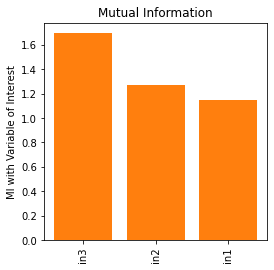

In [ ]:
mi = {}
for column in toy.columns:
    if column == 'out':
        continue
    mi[column] = mutual_information(prob(toy[['out', column]].values), 1)

plot_mi(mi)

The plot of input and output signals in the first section might give an impression that the toy model's output is closer to the two sine signals than to `in3`, but the linear regression below confirms the MI result. 

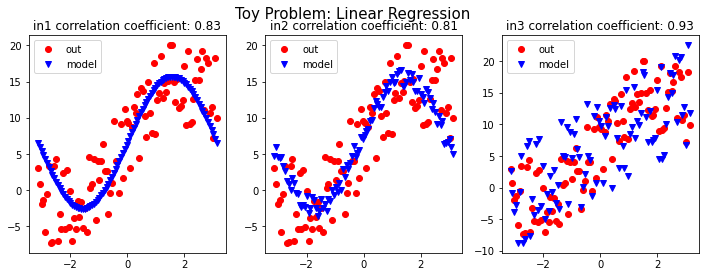

In [ ]:
model = []
var_rval = []
for column in toy.columns:
    if column == 'out':
        continue
    slope, intercept, rvalue, pvalue, stderr = linregress(toy[column].values, toy['out'].values)  
    model.append((slope*toy[column].values + intercept).reshape(len(toy), 1))
    var_rval.append((column, rvalue))

plot_lingress(pd.DataFrame(np.hstack(model), columns=var_rval), toy)

The result should in fact be expected given an output defined as $out = 2 \times in_1 + 3 \times in_2 + 6 \times in_3$ with the sixfold multiplier on $in_3$ greater than the sum of multipliers on the other signals, all three of which have an amplitude of 1.  

#### Conditional Mutual Information

Conditional mutual information (CMI) between a variable of interest, $X$, and a feature, $Y$, given the selection of another feature, $Z$, is given by

$I(X;Y|Z) = H(X|Z)-H(X|Y,Z)$

where $H(X|Z)$ is the CSE of $X$ conditional on $Z$ and $H(X|Y, Z)$ is the CSE of $X$ conditional on both $Y$ and $Z$.

In this code cell, because marginalization over $j$ removes a dimension, any conditional indices pointing to subsequent dimensions are decremented by 1.

In [ ]:
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z."""
    
    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

Apply `conditional_mutual_information` to the toy problem to find CMI between `out` and either `in2` or `in3`, conditional on `in1`.

In [ ]:
print("I(out;in2|in1) = {:.2f}".format(conditional_mutual_information(prob(toy[['out', 'in2', 'in1']].values), 1, 2)))
print("I(out;in3|in1) = {:.2f}".format(conditional_mutual_information(prob(toy[['out', 'in3', 'in1']].values), 1, 2)))

I(out;in2|in1) = 0.59
I(out;in3|in1) = 1.73


Given the sine signal, `in1`, if you try to predict the output from one of the remaining signals, you find that the linear function, `in3` contributes more information than the noisy sine, `in2`.

Ideally, to select a model's $k$ most relevant of $n$ features, you could maximize $I({X_k}; Y)$, the MI between a set of $k$ features, $X_k$, and variable of interest, $Y$. This is a hard calculation because $n \choose k$ grows rapidly in real-world problems.

## Solving Feature Selection on a Quantum Computer
There are different methods of approximating the hard calculation of optimally selecting $n \choose k$ features to maximize MI. The approach followed here assumes conditional independence of features and limits CMI calculations to permutations of three features. The optimal set of features, $S$, is then approximated by:

$\arg \max_S \sum_{i \in S} \left \{ I(X_i;Y) + \sum_{j \in S, j \ne i} I(X_j;Y |X_i) \right \}$


The left-hand component, $I(X_i;Y)$, represents MI between the variable of interest and a particular feature; maximizing selects features that best predict the variable of interest. The right-hand component, $I(X_j;Y |X_i)$, represents conditional MI between the variable of interest and a feature given the prior selection of another feature; maximizing selects features that complement information about the variable of interest rather than provide redundant information.

This approximation is still a hard calculation. The following subsection demonstrates a method for formulating it for solution on the D-Wave quantum computer. The method is based on the 2014 paper, [Effective Global Approaches for Mutual Information Based Feature Selection](https://dl.acm.org/citation.cfm?id=2623611), by Nguyen, Chan, Romano, and Bailey published in the Proceedings of the 20th ACM SIGKDD international conference on knowledge discovery and data mining.

## MIQUBO: QUBO Representation of Feature Selection
D-Wave systems solve binary quadratic models (BQM)&mdash;the Ising model traditionally used in statistical mechanics and its computer-science equivalent, the quadratic unconstrained binary optimization (QUBO) problem. Given $N$ variables $x_1,...,x_N$, where each variable $x_i$ can have binary values $0$ or $1$, the system finds assignments of values that minimize,
    
$\sum_i^N q_ix_i + \sum_{i<j}^N q_{i,j}x_i  x_j$,
    
where $q_i$ and $q_{i,j}$ are configurable (linear and quadratic) coefficients. To formulate a problem for the D-Wave system is to program $q_i$ and $q_{i,j}$ so that assignments of $x_1,...,x_N$ also represent solutions to the problem.

For feature selection, the Mutual Information QUBO (MIQUBO) method formulates a QUBO based on the approximation above for $I({X_k}; Y)$, which can be submitted to the D-Wave quantum computer for solution.

The reduction of scope to permutations of three variables in this approximate formulation for MI-based optimal feature selection makes it a natural fit for reformulation as a QUBO: 

<table style="width:75%">
  <tr>
    <th width="10%"></th>
    <th width="35%">Formula</th>
    <th width="10%">Optimization</th> 
    <th width="10%">Linear Terms</th>
    <th width="15%">Quadratic Terms</th>
  </tr>
  <tr>
    <td><b>Feature Selection</b></td> 
    <td>$\sum_{i \in S} \left \{ I(X_i;Y) + \sum_{j \in S, j \ne i} I(X_j;Y |X_i) \right \}$</td>
    <td>Maximize</td> 
    <td>$I(X_i;Y)$</td>
    <td>$I(X_j;Y |X_i)$</td>
  </tr>
  <tr>
    <td><b>QUBO</b></td>
    <td>$\sum_i^N q_ix_i + \sum_{i < j}^N q_{i,j}x_i  x_j$</td>
    <td>Minimize</td> 
    <td>$q_ix_i$</td>
    <td>$q_{i,j}x_ix_j$</td>
  </tr>
</table>

You can represent each choice of $n \choose k$ features as the value of solution $x_1,...,x_N$ by encoding $x_i=1$ if feature $X_i$ should be selected and $x_i=0$ if not. With solutions encoded this way, you can represent the QUBO in matrix format, $\mathbf{x}^T \mathbf{Q x}$, where $\mathbf Q$ is an $n$ x $n$ matrix and $\mathbf{x}$ is an $n$ x $1$ matrix (a vector) that should have $k$ ones representing the selected features. 

To map the feature-selection formula to a QUBO, set the elements of $\mathbf Q$ such that

 * diagonal elements (linear coefficients) represent MI: $Q_{ii} \leftarrow -I(X_i;Y)$ 
 * non-diagonal elements (quadratic elements) represent CMI: $Q_{ij} \leftarrow -I(X_j;Y |X_i)$

These QUBO terms are negative because the quantum computer seeks to minimize the programmed problem while the feature-selection formula maximizes. The following subsection codes this and then completes the formulation by adding the $n \choose k$ constraint to the QUBO.  

### MIQUBO on the Toy Problem
This subsection applies the MIQUBO formulation to the toy problem by configuring the QUBO in three parts: (1) linear biases that maximize MI between the variable of interest and each feature (2) quadratic biases that maximize CMI between the variable of interest and each feature, given the prior choice of another feature (3) selection of just $k$ features.

Create a BQM and set the linear coefficients as the MI between `out` and each potential feature. 

In [ ]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

for column in toy.columns:

    if column == 'out':
        continue

    mi = mutual_information(prob(toy[['out', column]].values), 1)
    bqm.add_variable(column, -mi)

for item in bqm.linear.items():
    print("{}: {:.3f}".format(item[0], item[1]))

in1: -1.147
in2: -1.269
in3: -1.696


Set the quadratic coefficients as the MI between `out` and each potential feature conditional on the other features.

In [ ]:
for f0, f1 in itertools.combinations(['in1', 'in2', 'in3'], 2):
    cmi_01 = conditional_mutual_information(prob(toy[['out', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(toy[['out', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()     # scale the BQM to (-1, 1) biases

for item in bqm.quadratic.items():
    print("{}: {:.3f}".format(item[0], item[1]))

('in1', 'in2'): -0.326
('in1', 'in3'): -0.899
('in2', 'in3'): -1.000


Use Ocean software's [dimod](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/sdk_index.html) [ExactSolver()](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampler_composites/samplers.html) to find an exact solution of the BQM, which currently represents a minimization of MI and CMI, and plot the results.

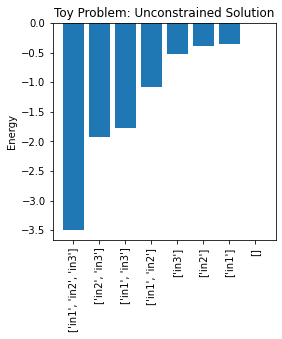

In [ ]:
sampler = dimod.ExactSolver()

result = sampler.sample(bqm)

plot_solutions(result)

Unsurprisingly, the best solution (lowest-energy solution for the minimized QUBO) employs all three input signals because the current QUBO mapping does not constrain the number of selected features. In those solutions where only two are selected, models that select `in3` are better than the one that selects just `in1` and `in2`.

### Penalizing Non-k Selections
How do you program  on the quantum computer a constraint that exactly $k$ features be selected? By penalizing solutions that select greater or fewer than $k$ features. If you add 

$P = \alpha (\sum_{i=1}^n x_i - k)^2$ 

to the QUBO, where penalty $P$ is positive whenever the number of $1$s in solution $x_1,...,x_N$ is not $k$, a large enough $\alpha$ can ensure that such solutions are no longer minima of the problem.  

Set set a constraint that $k=2$ with a penalty amplitude of $4$ (you can rerun this cell with varying values of `strength` to see the penalty range from ineffective to overshadowing the problem) and plot the solution. 

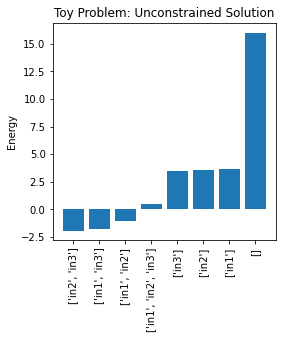

In [ ]:
k = 2
bqm.update(dimod.generators.combinations(bqm.variables, k, strength=4))

result = sampler.sample(bqm)

plot_solutions(result)

## Example Application: Predicting Survival of Titanic Passengers
This example illustrates the MIQUBO method by finding an optimal feature set for predicting survival of Titanic passengers. It uses records provided in file `formatted_titanic.csv`, which is a feature-engineered version of a public database of passenger information recorded by the ship's crew. In addition to a column showing survival for each passenger, its columns record gender, title, class, port of embarkation, etc. 

The next cell reads the file into a pandas DataFrame. 

In [ ]:
titanic = pd.read_csv("https://github.com/sparsh-ai/dwave-notebooks/raw/master/demos/feature-selection/data/formatted_titanic.csv")
titanic.head()

,pclass,survived,sex,age,fare,cabin,miss,master,mr,mrs,rare,alone,embarked port S,embarked port C,embarked port Q
0,1,1,1,2,2,True,True,False,False,False,False,True,True,False,False
1,1,1,0,0,1,True,False,True,False,False,False,False,True,False,False
2,1,0,1,0,1,True,True,False,False,False,False,False,True,False,False
3,1,0,0,2,1,True,False,False,True,False,False,False,True,False,False
4,1,0,1,2,1,True,False,False,False,True,False,False,True,False,False


Plot a ranking of MI between each feature and the variable of interest (survival).

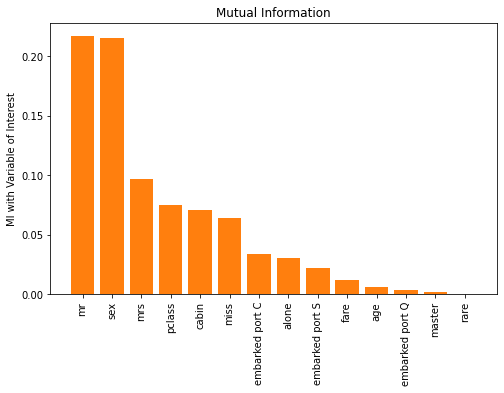

In [ ]:
mi = {}
features = list(set(titanic.columns).difference(('survived',)))

for feature in features:
    mi[feature] = mutual_information(prob(titanic[['survived', feature]].values), 1)

plot_mi(mi)

### Exact Versus Good Solutions: a Note on this Dataset
This example demonstrates a technique for solving a type of optimization problem on a quantum computer. The Titanic dataset provides a familiar, intuitive example available in the public domain. In itself, however, it is not a good fit for solving by sampling. 

The next cell plots the values of MI and CMI for all features and three-variable permutations. Notice the clustering of values in tight ranges of values.

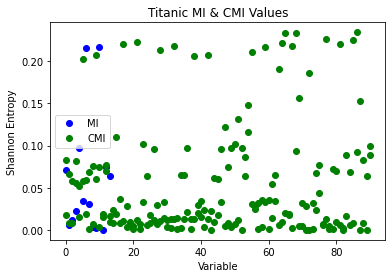

In [ ]:
plt.plot(range(len(features)), [mutual_information(prob(titanic[['survived', feature]].values), 1) for feature in features], 'bo')

plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')
plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')

plt.title("Titanic MI & CMI Values")
plt.ylabel("Shannon Entropy")
plt.xlabel("Variable")
plt.legend(["MI", "CMI"])

The plot below, obtained by exploiting the problem's small size and brute-force solving for all possible values, shows the solution space for a couple of choices of $k$. The left side shows the resulting energy for all possible assignments of values to $x_1...x_N$ (yellow) and those that satisfy the requirement of $n \choose k$ (blue); the right side focuses on only those that satisfy $n \choose k$ and highlights the optimal solution (red).

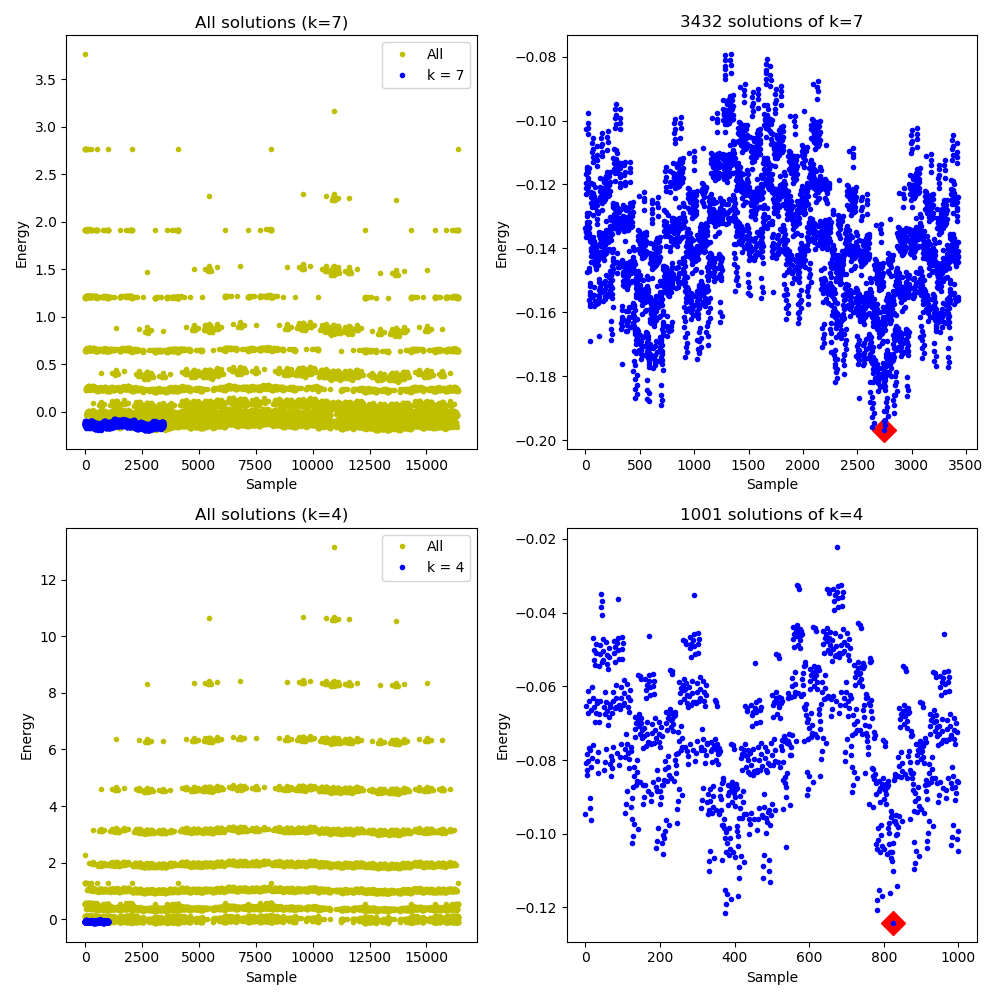

Notice the high number of valid solutions that form a small cluster (the energy difference between the five best solutions in the depicted graph is in the fourth decimal place). The quantum computer's strength is in quickly finding diverse good solutions to hard problems, it is not best employed as a double-precision numerical calculator. Run naively on this dataset, it finds numerous good solutions but is unlikely to find the exact optimal solution.

There are many techniques for reformulating problems for the D-Wave system that can improve performance on various metrics, some of which can help narrow down good solutions to closer approach an optimal solution. These are out of scope for this example. For more information, see the [D-Wave Problem-Solving Handbook](https://docs.dwavesys.com/docs/latest/doc_handbook.html), and examples in the [Ocean software documentation](https://docs.ocean.dwavesys.com/en/stable/index.html).

The remainder of this section solves the problem for just the highest-scoring features.

### Building the MI-Based BQM
Select 8 features with the top MI ranking found above. 

In [ ]:
keep = 8

sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
titanic = titanic[[column[0] for column in sorted_mi[0:keep]] + ["survived"]]
features = list(set(titanic.columns).difference(('survived',)))

print("Submitting for {} features: {}".format(keep, features))

Submitting for 8 features: ['cabin', 'embarked port C', 'sex', 'alone', 'mrs', 'pclass', 'miss', 'mr']


Calculate a BQM based on the problem's MI and CMI as done previously for the toy problem.

In [ ]:
#@markdown draw helper
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import networkx as nx
import sys

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, Label, LabelSet, ColumnDataSource
from bokeh.models import WheelZoomTool, ZoomInTool, ZoomOutTool, ResetTool, PanTool
from bokeh.plotting import from_networkx

me = sys.modules[__name__]
if not hasattr(me, 'bokeh_loaded'):
    output_notebook()
    bokeh_loaded = True

def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)      
    plot_size = 400
    text_size = '16pt'
     
    graph = from_networkx(g, nx.spring_layout)
    graph.node_renderer.glyph = Circle(size=35, fill_color='purple', fill_alpha=0.25)
    graph.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=2)
 
    pos = nx.spring_layout(g)
    data = {'xpos': [], 'ypos': [], 'label': []}
    for label, loc in pos.items():
        data['label'].append(label)
        data['xpos'].append(loc[0])
        data['ypos'].append(loc[1])
    labels = LabelSet(x='xpos', y='ypos', text='label', level='glyph', 
                      source=ColumnDataSource(data), x_offset=-1, y_offset=-1, 
                      text_color="blue", text_font_size='14pt', text_font_style='bold')    
    
    plot = Plot(plot_width=plot_size, plot_height=plot_size, x_range=Range1d(-1.3, 1.3), y_range=Range1d(-1.3, 1.3))
    plot.title.text = "BQM with {} nodes and {} edges".format(len(bqm), len(bqm.quadratic))
    
    tools = [WheelZoomTool(), ZoomInTool(), ZoomOutTool(), PanTool(), ResetTool()]
    plot.add_tools(*tools)
    plot.toolbar.active_scroll = tools[0]
    
    plot.renderers.append(graph)
    plot.add_layout(labels)
    plot.background_fill_color = "lightyellow"
        
    show(plot)
    
def plot_feature_selection(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

In [ ]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# add the features
for feature in features:
    mi = mutual_information(prob(titanic[['survived', feature]].values), 1)
    bqm.add_variable(feature, -mi)

for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()  

plot_bqm(bqm)

### Setting Up a QPU as a Solver
Set up a D-Wave system as your solver in the standard way described in the Ocean documentation's [Configuring Access to D-Wave Solvers](https://docs.ocean.dwavesys.com/en/stable/overview/sapi.html). 

*minor-embedding*, the mapping between the problem's variables to the D-Wave QPU's numerically indexed qubits, can be handled in a variety of ways and this affects solution quality and performance. Ocean software provides tools suited for different types of problems; for example, [dwave-system](https://docs.ocean.dwavesys.com/en/stable/docs_system/sdk_index.html) [EmbeddingComposite()](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html) has a heuristic for automatic embedding. This example uses [FixedEmbeddingComposite()](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html) with the embedding found using an algorithm tuned for cliques (complete graphs).

Helper function `qpu_working_graph` below creates a [*dwave-networkx*](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/sdk_index.html) graph that represents the *working graph* of the QPU selected by [DWaveSampler](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html), a Pegasus or Chimera graph with the same sets of nodes (qubits) and edges (couplers) as the QPU. Ocean software's [*minorminer*](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/sdk_index.html) finds an embedding for the required clique size in the working graph. 

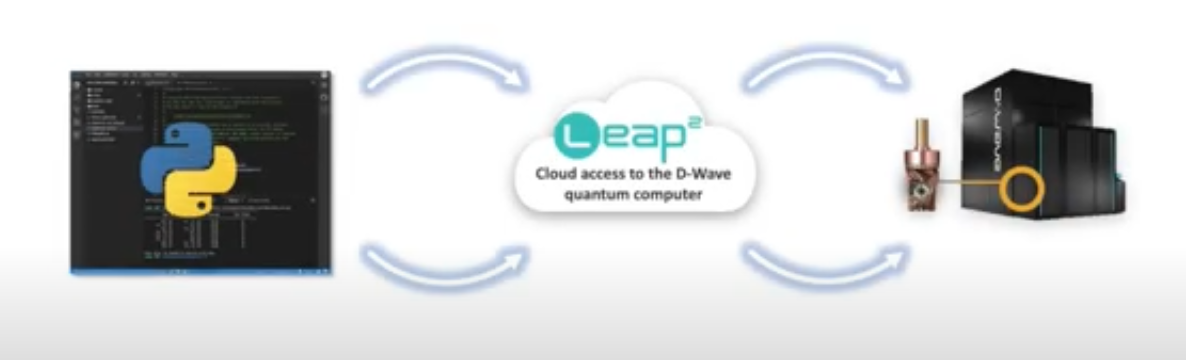

https://youtu.be/qafL1TVKpY0

https://docs.ocean.dwavesys.com/en/stable/overview/install.html

In [ ]:
!dwave setup

```text
Optionally install non-open-source packages and configure your environment.

Do you want to select non-open-source packages to install (y/n)? [y]: 

D-Wave Drivers
These drivers enable some automated performance-tuning features.
This package is available under the D-Wave EULA license.
The terms of the license are available online: https://docs.ocean.dwavesys.com/eula
Install (y/n)? [y]: 
Installing: D-Wave Drivers
Successfully installed D-Wave Drivers.

D-Wave Problem Inspector
This tool visualizes problems submitted to the quantum computer and the results returned.
This package is available under the D-Wave EULA license.
The terms of the license are available online: https://docs.ocean.dwavesys.com/eula
Install (y/n)? [y]: 
Installing: D-Wave Problem Inspector
Successfully installed D-Wave Problem Inspector.

Creating the D-Wave configuration file.
Configuration file not found; the default location is: /root/.config/dwave/dwave.conf
Configuration file path [/root/.config/dwave/dwave.conf]: 
Configuration file path does not exist. Create it? [y/N]: y
Profile (create new) [prod]: dev
API endpoint URL [skip]: https://cloud.dwavesys.com/sapi/
Authentication token [skip]: DEV-4595********************
Default client class [skip]: 
Default solver [skip]: 
Configuration saved.
```

In [ ]:
!dwave ping

Using endpoint: https://cloud.dwavesys.com/sapi/
Using solver: DW_2000Q_6
Submitted problem ID: 19ef1009-af13-4d82-9b5f-0b216259786c

Wall clock time:
 * Solver definition fetch: 900.507 ms
 * Problem submit and results fetch: 966.624 ms
 * Total: 1867.132 ms

QPU timing:
 * post_processing_overhead_time = 508 us
 * qpu_access_overhead_time = 1986 us
 * qpu_access_time = 10986 us
 * qpu_anneal_time_per_sample = 20 us
 * qpu_delay_time_per_sample = 21 us
 * qpu_programming_time = 10747 us
 * qpu_readout_time_per_sample = 198 us
 * qpu_sampling_time = 239 us
 * total_post_processing_time = 508 us


In [ ]:
def qpu_working_graph(qpu):
    "Return a dwave_networkx graph representing the working graph of a given QPU."
    
    dnx_graphs = {'chimera': dnx.chimera_graph, 'pegasus': dnx.pegasus_graph}

    dnx_graph = dnx_graphs[qpu.properties["topology"]["type"].lower()]

    return dnx_graph(qpu.properties["topology"]["shape"][0], 
                     node_list=qpu.nodelist, 
                     edge_list=qpu.edgelist)

In [ ]:
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from minorminer.busclique import find_clique_embedding

qpu = DWaveSampler()

qpu_working_graph = qpu_working_graph(qpu)
embedding = find_clique_embedding(bqm.variables, qpu_working_graph)

qpu_sampler = FixedEmbeddingComposite(qpu, embedding)

print("Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))

Maximum chain length for minor embedding is 2.


This problem is small enough to be solved in its entirety on a D-Wave 2000Q QPU. For datasets with higher numbers of features, D-Wave Ocean's [dwave-hybrid](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/sdk_index.html) tool can be used to break the BQM into smaller pieces for serial submission to the QPU and/or parallel solution on classical resources. Here, an out-of-the-box hybrid sampler, [Kerberos](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html) is used.    

In [ ]:
from hybrid.reference.kerberos import KerberosSampler

kerberos_sampler = KerberosSampler() 

### Submit the Problem for All k Values
For all numbers of selected features, $k$, set a $n \choose k$ penalty, submit an updated BQM for solution, and at the end plot the selected features.

Submitting for k=1
Submitting for k=2
Submitting for k=3
Submitting for k=4
Submitting for k=5
Submitting for k=6
Submitting for k=7
Submitting for k=8


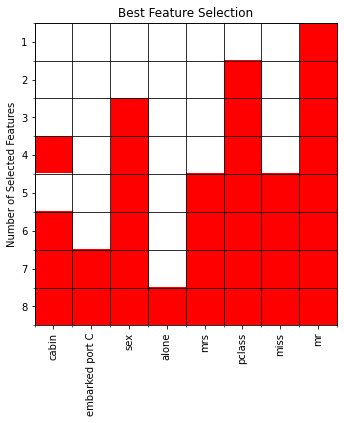

In [ ]:
selected_features = np.zeros((len(features), len(features)))
for k in range(1, len(features) + 1):
    print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, k, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()
    
    best = kerberos_sampler.sample(kbqm, 
                                   qpu_sampler=qpu_sampler, 
                                   qpu_reads=10000, 
                                   max_iter=1,
                                   qpu_params={'label': 'Notebook - Feature Selection'}
                                  ).first.sample
    
    for fi, f in enumerate(features):
        selected_features[k-1, fi] = best[f]

plot_feature_selection(features, selected_features)

## Conclusion

In this tutorial, we understood some basics of feature selection and applied our learning on a toy dataset using DWave quantum processor. [This](https://cloud.dwavesys.com/leap/) is the link where you can register to get some free access. Next, you can take help of [this](https://github.com/sparsh-ai/dwave-notebooks) repo and explore some more examples. Also, explore [this](https://github.com/qcpolimi/CQFS) repo and associated [paper](https://www.mdpi.com/1099-4300/23/8/970/pdf) to know how to perform feature selection on recsys datasets - Movielens, CiteULike, and Xing (RecSys'17).

Copyright &copy; D-Wave Systems Inc.